In [38]:
import numpy as np                      
import pandas as pd                     
import matplotlib.pyplot as plt         
import seaborn as sns                    

import warnings
warnings.filterwarnings('ignore')

In [4]:
taxi_data =  pd.read_csv("nyc_taxi_trip_duration.csv")
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848
...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447


So the data contains 11 characteristics of almost 1.5 million trips.

Let's conditionally divide the features into several groups:
Data about the client and taxi company:

id - unique trip identifier

vendor_id - unique identifier of the vendor (taxi company) associated with the trip record

Time characteristics:

pickup_datetime - date and time when the trip counter was turned on

dropoff_datetime - date and time when the counter was dropped

Geographic information:

pickup_longitude - the longitude at which the pickup was turned on

pickup_latitude - the latitude at which the pickup was turned on

dropoff_longitude - the longitude at which the counter was dropped

dropoff_latitude - the latitude at which the counter was turned off

Other signs:

passenger_count - number of passengers in the vehicle (value entered by the driver)

store_and_fwd_flag - a flag that indicates whether the trip record is stored in the vehicle's memory before being sent to the supplier. Y - store and forward, N - do not store or forward the trip.

Target feature:

trip_duration - trip duration in seconds

# 2.1 General overview, data preparation and cleaning. 
Let's look at the time frames presented in the dataset.

In [5]:
taxi_data.shape

(729322, 11)

In [6]:
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


In [7]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

print('Presented period pickup: {} - {}'.format(taxi_data['pickup_datetime'].dt.date.min(), taxi_data['pickup_datetime'].dt.date.max()))
print('Presented period dropoff: {} - {}'.format(taxi_data['dropoff_datetime'].dt.date.min(), taxi_data['dropoff_datetime'].dt.date.max()))

Presented period pickup: 2016-01-01 - 2016-06-30
Presented period dropoff: 2016-01-01 - 2016-07-01


So,

    Trip data provided by two taxi companies,
    the flag of storing the trip message and sending it to the provider 'store_and_fwd_flag' can be called non-informative, because 99.44% of trips without storing information,
    the 'id' attribute is unique and therefore not informative,
    not all trips contain information about the number of passengers, we see the indication - 0 passengers,
    There are anomalous outliers in the target feature, such as a trip of 40.81 hours (3526282 sec.), as well as trips of 1 second

In [8]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date 
    data['pickup_hour'] = data['pickup_datetime'].dt.hour   
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek
    return data

add_datetime_features(taxi_data)
print(taxi_data[['pickup_date', 'pickup_hour', 'pickup_day_of_week']].head())
print('Quantity of trips daily:', np.round(taxi_data['pickup_date'].count()/taxi_data['pickup_date'].nunique()))

  pickup_date  pickup_hour  pickup_day_of_week
0  2016-02-29           16                   0
1  2016-03-11           23                   4
2  2016-02-21           17                   6
3  2016-01-05            9                   1
4  2016-02-17            6                   2
Quantity of trips daily: 4007.0


In [9]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

def add_holiday_features(data1, data2):
    holidays = data2['date'].tolist()
    data1['pickup_holiday'] = data1['pickup_date'].apply(lambda x: 1 if str(x) in holidays else 0)
    return data1
add_holiday_features(taxi_data, holiday_data)
print('Quantity of trips in working days(0, %) and holidays(1, %): ', taxi_data['pickup_holiday'].value_counts()*100/len(taxi_data), sep='\n')

Quantity of trips in working days(0, %) and holidays(1, %): 
0    96.481938
1     3.518062
Name: pickup_holiday, dtype: float64


In [10]:
cols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
osrm_data = pd.read_csv('osrm_data_train.zip', usecols = cols)
osrm_data.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [11]:
def add_osrm_features(data1, data2):
    data = data1.merge(data2, on='id', how='left')
    return data
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,2016-02-29,16,0,0,1630.9,172.5,6.0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,2016-03-11,23,4,0,5428.7,581.8,11.0
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,2016-02-21,17,6,0,9327.8,748.9,9.0
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,2016-01-05,9,1,0,8022.7,612.2,13.0
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,2016-02-17,6,2,0,5468.7,645.0,8.0


In [12]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    EARTH_RADIUS = 6371 
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [13]:
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    return data
add_geographical_features(taxi_data)
taxi_data[['haversine_distance', 'direction']].head()

,haversine_distance,direction
0,1.199073,-135.634530
1,4.129111,-172.445217
2,7.250753,34.916093
3,2.361097,10.043567
4,4.328534,34.280582


In [46]:
def add_cluster_features(data):
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                    data[['dropoff_latitude', 'dropoff_longitude']]))
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    predictions = kmeans.predict(coords)
    data['geo_cluster'] = predictions
    return data
add_cluster_features(taxi_data)
taxi_data['geo_cluster'].value_counts()

6    296972
2    196467
0    169012
5     22649
7     20103
4     14674
3      9238
8         6
9         2
1         1
Name: geo_cluster, dtype: int64

2.2.5 Creating new features based on external weather data 

    Weather is an important factor affecting road traffic. For example, snow and rain can make driving difficult and increase travel times.

    From the file with information about weather conditions in New York in 2016, we are interested in the following columns:

    time — measurement date (with an interval of one hour);
    temperature — temperature;
    visibility — visibility;
    wind speed — average wind speed;
    precip — amount of precipitation;
    events — weather phenomena: Rain — rain, Snow — snow, Fog — fog, None — absence of weather phenomena.
    Let's create a function add_weather_features() that takes two tables as input: a table with trip data and a table with hourly weather data.
    The function returns an updated table with trip data with 5 columns added to it:

    temperature - temperature;
    visibility - visibility;
    wind speed - average wind speed;
    precip - amount of precipitation;
    events - weather phenomena

In [14]:
columns = ['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']
weather_data = pd.read_csv('weather_data.zip', usecols=columns)
weather_data.head()

,time,temperature,visibility,wind speed,precip,events
0,2015-12-31 02:00:00,7.8,8.0,5.6,0.8,None
1,2015-12-31 03:00:00,7.2,12.9,7.4,0.3,None
2,2015-12-31 04:00:00,7.2,12.9,0.0,0.0,None
3,2015-12-31 05:00:00,7.2,14.5,7.4,0.0,None
4,2015-12-31 06:00:00,7.2,11.3,5.6,0.0,None


In [43]:
weather_data['time'] = pd.to_datetime(weather_data['time'])
def add_weather_features(data1, data2):
    data2['date'] = data2['time'].dt.date
    data2['hour'] = data2['time'].dt.hour
    data = data1.merge(data2, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    return data.drop(['time', 'date', 'hour'], axis=1)
taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,...,visibility_x,wind speed_x,precip_x,events_x,trip_duration_log,temperature_y,visibility_y,wind speed_y,precip_y,events_y
0,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,400,2016-02-29,...,16.1,11.1,0.0,None,5.993961,15.6,16.1,11.1,0.0,None
1,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,1100,2016-03-11,...,16.1,7.4,0.0,None,7.003974,10.6,16.1,7.4,0.0,None
2,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,1635,2016-02-21,...,16.1,0.0,0.0,None,7.400010,12.2,16.1,0.0,0.0,None
3,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,1141,2016-01-05,...,16.1,9.3,0.0,None,7.040536,-11.1,16.1,9.3,0.0,None
4,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,848,2016-02-17,...,16.1,7.4,0.0,None,6.744059,2.8,16.1,7.4,0.0,None


In [15]:
weather_data['time'] = pd.to_datetime(weather_data['time'])
def add_weather_features(data1, data2):
    data2['date'] = data2['time'].dt.date
    data2['hour'] = data2['time'].dt.hour
    data = data1.merge(data2, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    return data.drop(['time', 'date', 'hour'], axis=1)
taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,temperature,visibility,wind speed,precip,events
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,1630.9,172.5,6.0,1.199073,-135.634530,15.6,16.1,11.1,0.0,None
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,5428.7,581.8,11.0,4.129111,-172.445217,10.6,16.1,7.4,0.0,None
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,9327.8,748.9,9.0,7.250753,34.916093,12.2,16.1,0.0,0.0,None
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,8022.7,612.2,13.0,2.361097,10.043567,-11.1,16.1,9.3,0.0,None
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,5468.7,645.0,8.0,4.328534,34.280582,2.8,16.1,7.4,0.0,None


# 2.3 Filling gaps in new features added to the original trip dataset. 
Let's create a function fill_null_weather_data() that takes a table of trip data as input. The function should fill in missing values ​​in columns.

The gaps in the columns with weather conditions - temperature, visibility, wind speed, precip - will be filled with the median value of temperature, humidity, wind speed and visibility depending on the start date of the trip.
The gaps in the column events will be filled with the line 'None' - a symbol of the absence of weather phenomena (snow/rain/fog).

We will fill the gaps in the columns with information from OSRM - total_distance, total_travel_time and number_of_steps with the median value for the columns.

# IDA

In [16]:
null_in_data = taxi_data.isnull().sum()
print('Features witn null: ', null_in_data[null_in_data > 0], sep='\n')
def fill_null_weather_data(data):
    cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in cols:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))
    data['events'] = data['events'].fillna('None')
    cols2 = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in cols2:
        data[col] = data[col].fillna(data[col].median())
    return data

fill_null_weather_data(taxi_data)

Features witn null: 
total_distance          1
total_travel_time       1
number_of_steps         1
temperature          6004
visibility           6004
wind speed           6004
precip               6004
events               6004
dtype: int64


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,temperature,visibility,wind speed,precip,events
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,1630.9,172.5,6.0,1.199073,-135.634530,15.6,16.1,11.1,0.0,None
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,5428.7,581.8,11.0,4.129111,-172.445217,10.6,16.1,7.4,0.0,None
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,9327.8,748.9,9.0,7.250753,34.916093,12.2,16.1,0.0,0.0,None
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,8022.7,612.2,13.0,2.361097,10.043567,-11.1,16.1,9.3,0.0,None
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,5468.7,645.0,8.0,4.328534,34.280582,2.8,16.1,7.4,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,...,1568.6,128.6,6.0,1.120223,93.403814,17.8,16.1,7.4,0.0,None
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,...,1582.8,221.1,6.0,0.728705,-147.443222,7.8,16.1,13.0,0.0,None
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,...,2876.0,342.8,4.0,2.298776,-172.335340,17.2,16.1,5.6,0.0,None
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,...,1631.0,202.9,9.0,0.846316,-42.964076,20.6,14.5,0.0,0.0,None


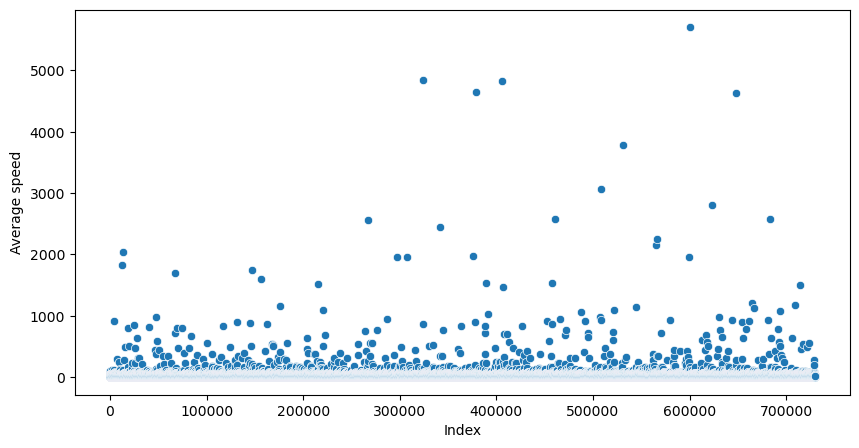

In [17]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

In [18]:
duration_mask = taxi_data['trip_duration'] > (60*60*24)
print('Taxi trips over 24 hours: ', *taxi_data[duration_mask].index)
print('Speed of taxis over 300km/hours: ', len(taxi_data[avg_speed > 300].index))

Taxi trips over 24 hours:  21813
Speed of taxis over 300km/hours:  197


In [19]:
taxi_data = taxi_data[(avg_speed < 300)&(taxi_data['trip_duration'] < (60*60*24))]
taxi_data.drop(['id', 'store_and_fwd_flag', 'pickup_holiday'], axis=1, inplace=True)
taxi_data.shape

(729124, 22)

# Exploratory Data Analysis (EDA) 

The main metric of the quality of the solution of the given problem in ML we define RMSLE - Root Mean Squared Log Error, which is calculated based on the target variable on a logarithmic scale. We logarithm the feature of the duration of the trip and will consider the logarithm as the target feature in the analysis:
𝑡𝑟𝑖𝑝_𝑑𝑢𝑟𝑎𝑡𝑖𝑜𝑛_𝑙𝑜𝑔=𝑙𝑜𝑔(𝑡𝑟𝑖𝑝_𝑑𝑢𝑟𝑎𝑡𝑖𝑜𝑛+1)

In [20]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

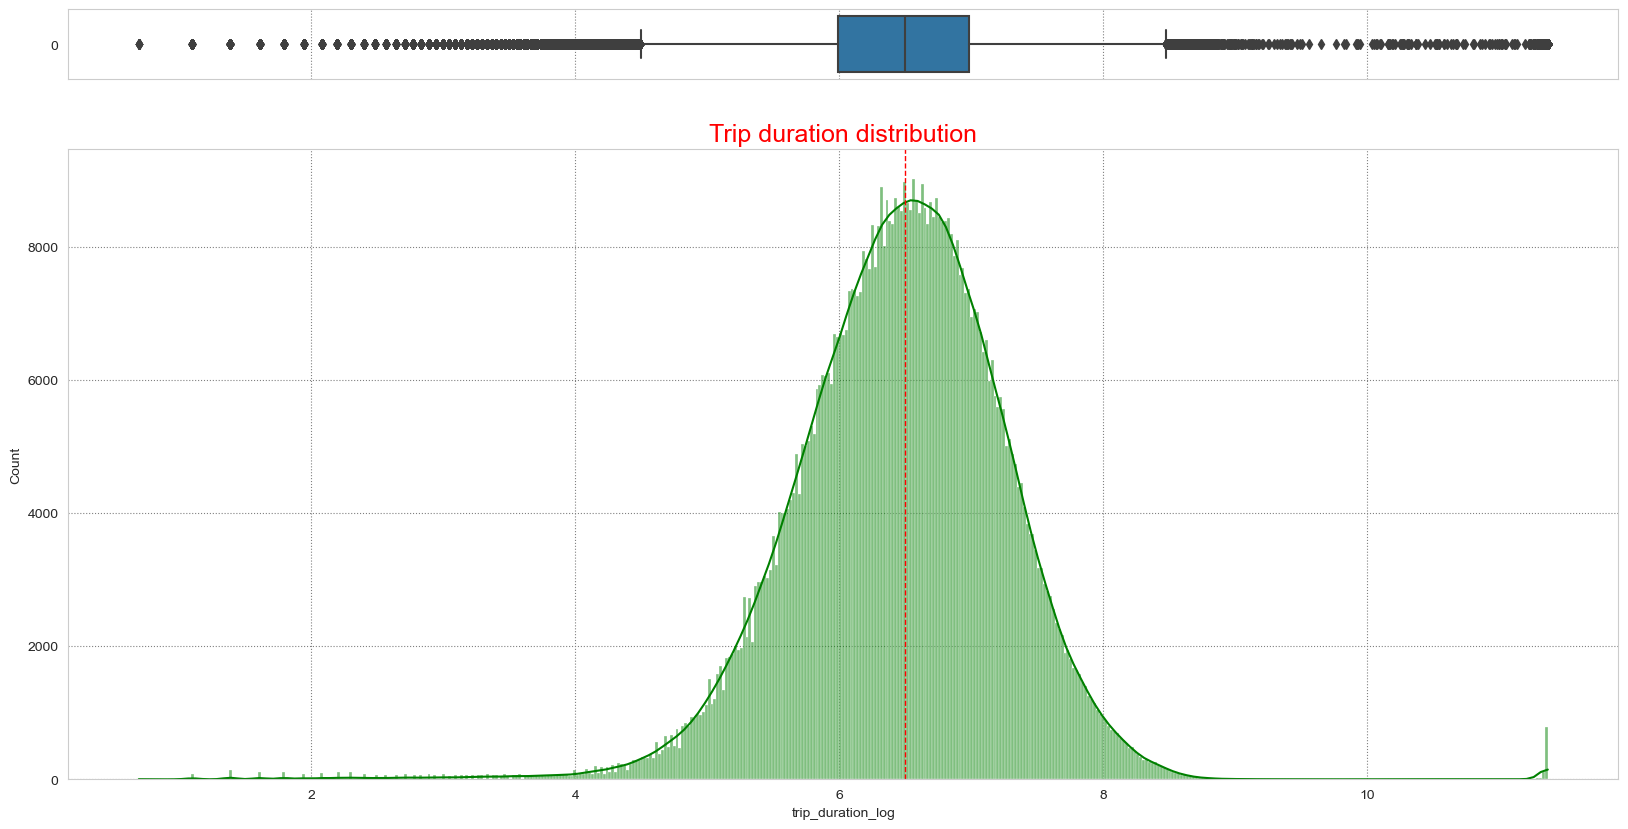

In [21]:
sns.set_style("whitegrid", {"grid.color": ".5", "grid.linestyle": ":"})
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios':{.10, .90}}, figsize = (20, 10)) 
sns.boxplot(taxi_data['trip_duration_log'], orient="h", ax=ax_box)
sns.histplot(taxi_data['trip_duration_log'], kde=True, color='green', ax=ax_hist)
ax_hist.axvline(taxi_data['trip_duration_log'].median(), color='red', linestyle='--', linewidth=1)
plt.title('Trip duration distribution', fontsize=18, color='r')
plt.show()

# 3.2 Comparison of trip duration (trip_duration_log) depending on the taxi company (vendor_id). 

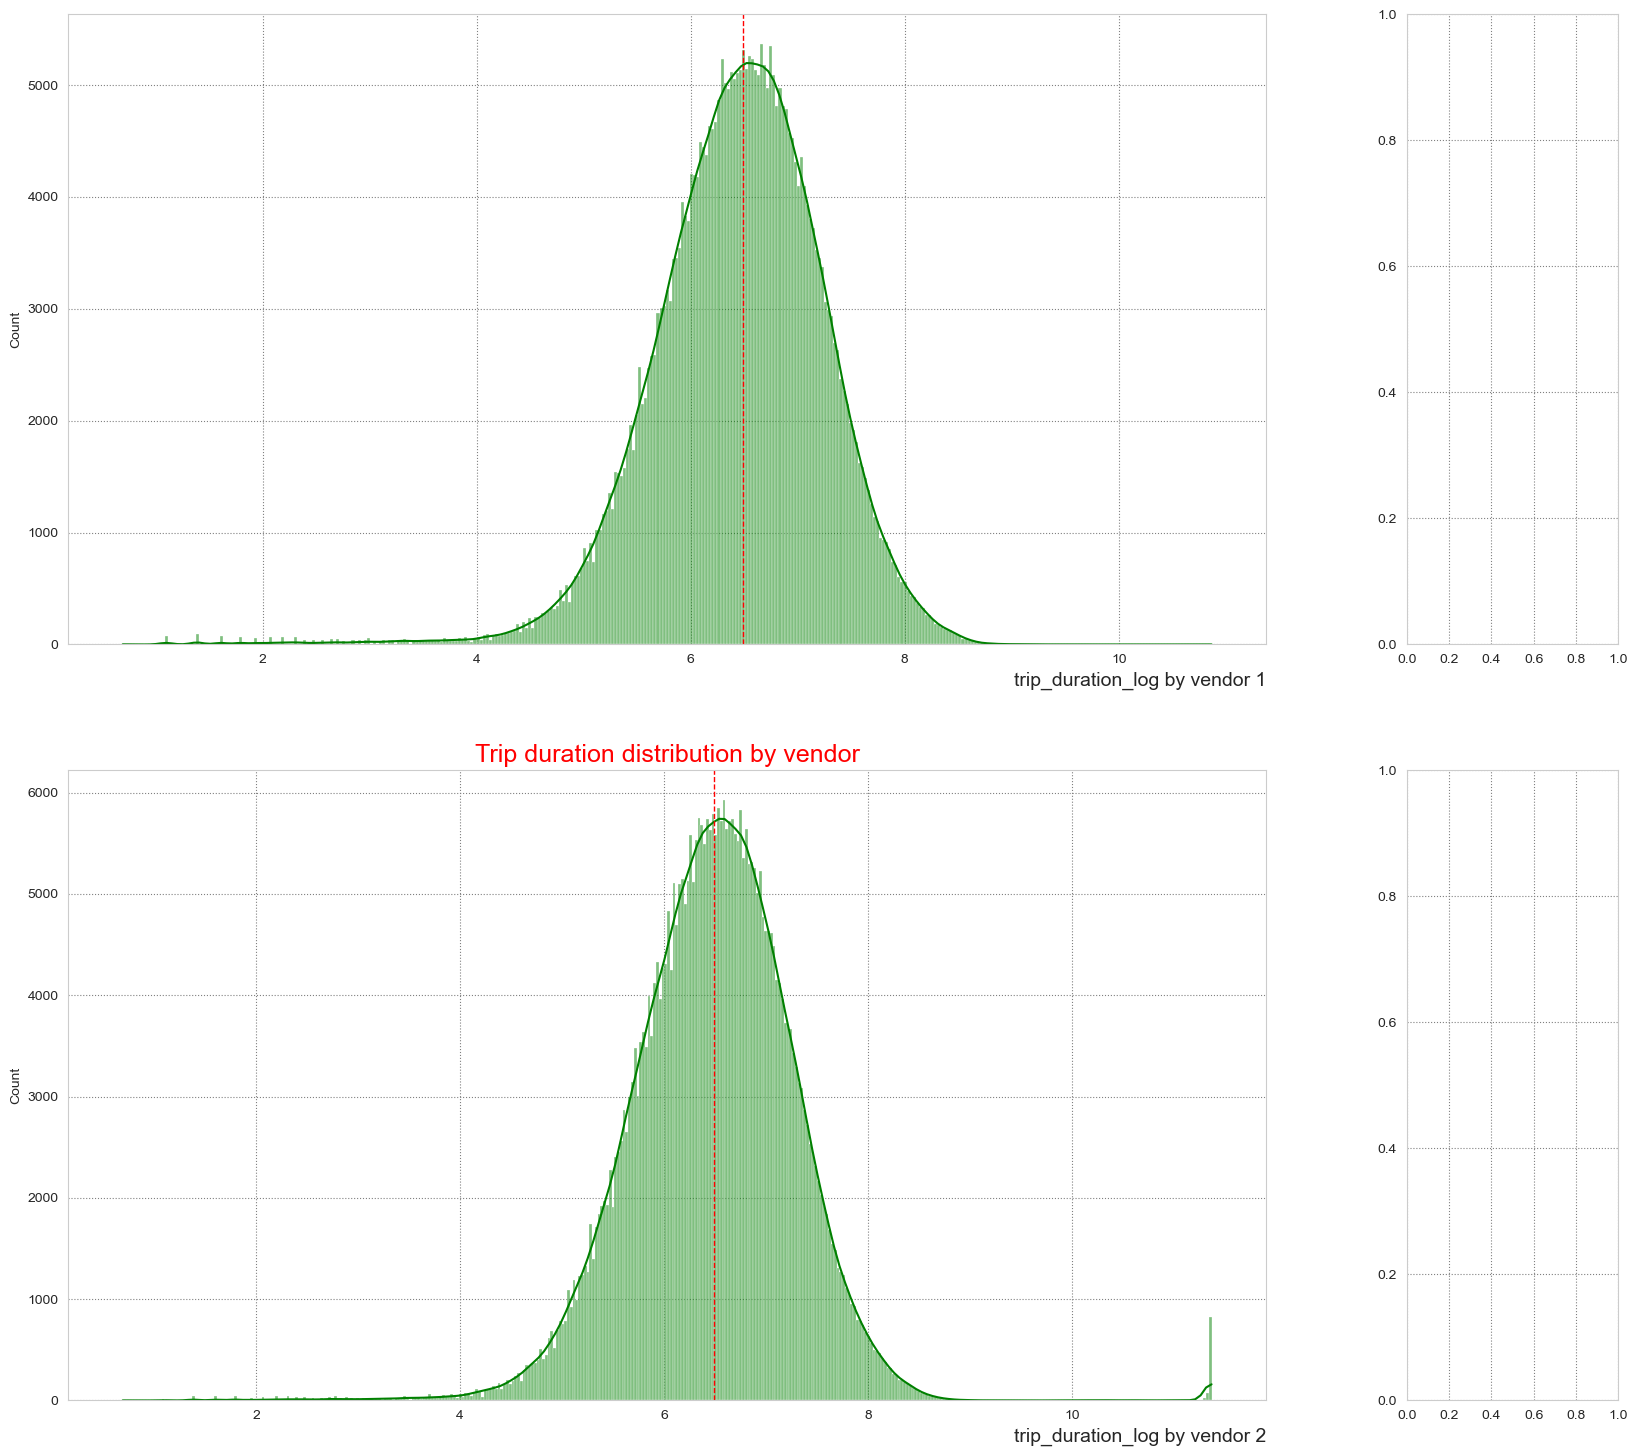

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20, 18), gridspec_kw={'width_ratios':{.85, .15}})
sns.histplot(x=taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'], kde=True, color='green', ax = ax[0][0])
ax[0][0].set_xlabel('trip_duration_log by vendor 1', loc='right', fontsize=14)
ax[0][0].axvline(taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'].median(), color='red', linestyle='--', linewidth=1) 
# sns.boxplot(taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'], orient='v', ax=ax[0][1])
sns.histplot(x=taxi_data[taxi_data['vendor_id']==2]['trip_duration_log'], kde=True, color='green', ax=ax[1][0])
ax[1][0].set_xlabel('trip_duration_log by vendor 2', loc='right', fontsize=14)
ax[1][0].axvline(taxi_data[taxi_data['vendor_id']==1]['trip_duration_log'].median(), color='red', linestyle='--', linewidth=1)
ax[1][0].set_title('Trip duration distribution by vendor', loc='center', fontsize=18, color='r')
# sns.boxplot(taxi_data[taxi_data['vendor_id']==2]['trip_duration_log'], orient='v')
plt.show()

# 3.3 Distribution of trip duration (trip_duration_log) depending on temperature (temperature).

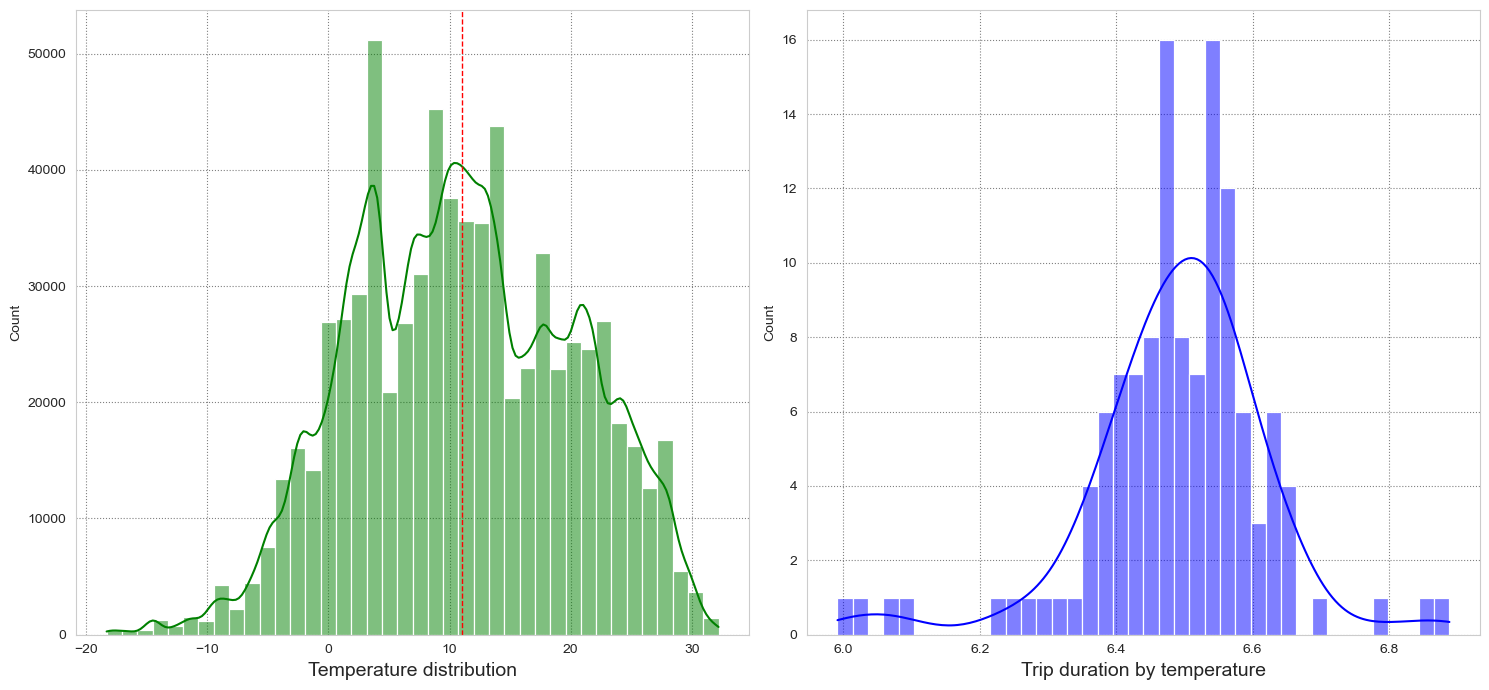

In [29]:
temp = taxi_data.groupby('temperature')['trip_duration_log'].median()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(taxi_data, x='temperature', kde=True, color='green', bins=40, ax = ax[0])
ax[0].set_xlabel('Temperature distribution', fontsize=14)
ax[0].axvline(taxi_data['temperature'].median(), color='red', linestyle='--', linewidth=1) # отобразим медианное значение
sns.histplot(temp, bins=40, color='blue', kde=True, ax = ax[1])
ax[1].set_xlabel('Trip duration by temperature', fontsize=14)
plt.tight_layout()
plt.show()

# 3.4 Distribution of trip duration (trip_duration) depending on the shortest trip time according to OSRM (total_travel_time). 

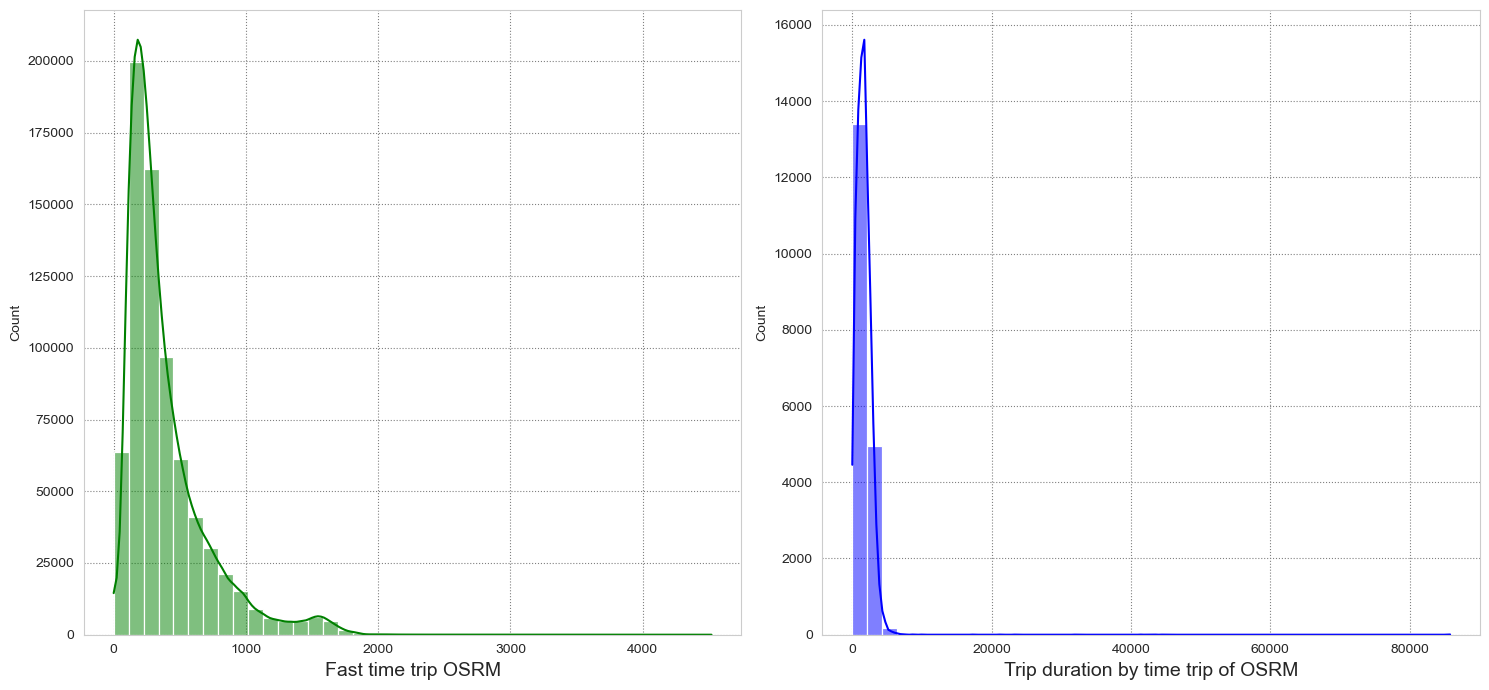

In [30]:
time_trip = taxi_data.groupby('total_travel_time')['trip_duration'].median()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(taxi_data, x='total_travel_time', kde=True, color='green', bins=40, ax = ax[0])
ax[0].set_xlabel('Fast time trip OSRM', fontsize=14)
sns.histplot(time_trip, bins=40, color='blue', kde=True, ax = ax[1])
ax[1].set_xlabel('Trip duration by time trip of OSRM', fontsize=14)
plt.tight_layout()
plt.show()

# 3.5 Visualization of the number of trips depending on the hour of the day (pickup_hour) and the dependence of the duration of trips (trip_duration) on this factor.

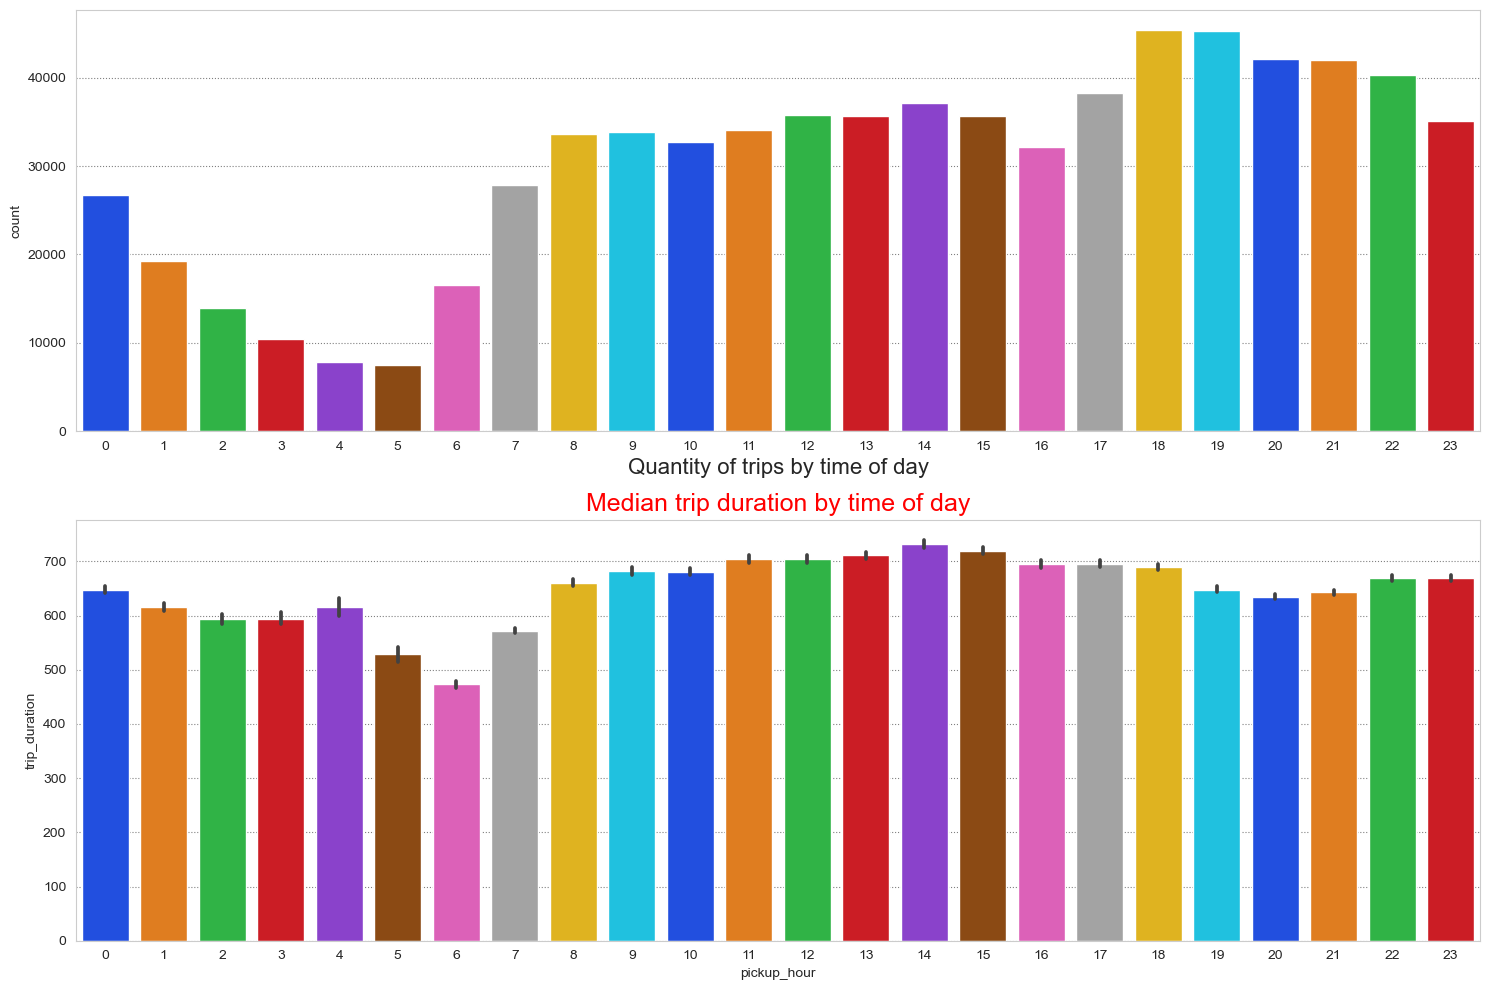

In [31]:
fig, ax = plt.subplots(2, figsize=(15, 10))
sns.countplot(taxi_data, x='pickup_hour', palette='bright', ax=ax[0])
ax[0].set_xlabel('Quantity of trips by time of day', fontsize=16)
sns.barplot(taxi_data, x='pickup_hour', y='trip_duration', estimator='median', palette='bright', ax=ax[1])
plt.title('Median trip duration by time of day', fontsize=18, color='r')
plt.tight_layout()
plt.show()

***Conclusion:***
*The largest number of taxi trips occurs between 6:00 PM and 10:00 PM, when people return home after work.*
The longest trips are observed between 9:00 AM and 6:00 PM, which is the usual working time of the day.
Thus, this factor (time of day) affects the duration of the trip, but we will determine its significance later.

# 3.6 Visualization of the number of trips depending on the day of the week (pickup_day_of_week) and the dependence of the duration of trips (trip_duration) on the day of the week.

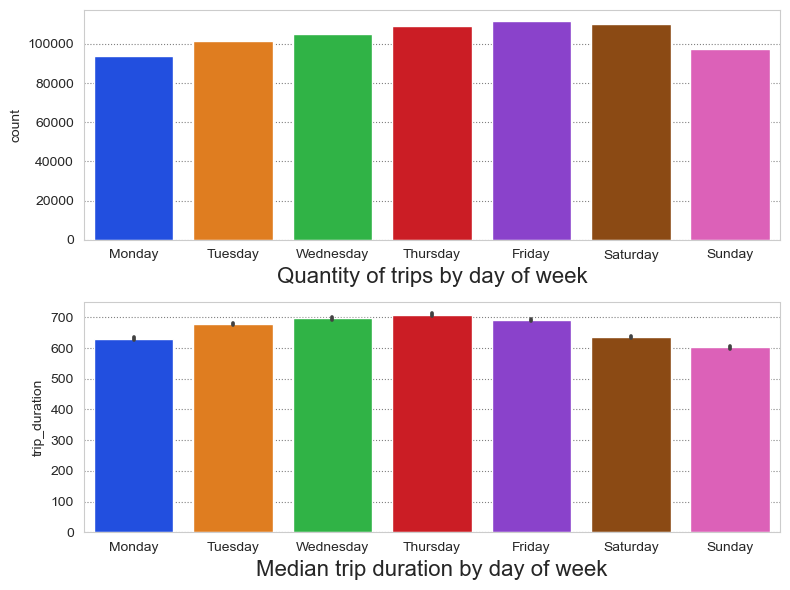

In [32]:
fig, ax = plt.subplots(2, figsize=(8, 6))
sns.countplot(taxi_data, x='pickup_day_of_week', palette='bright', ax=ax[0])
ax[0].set_xlabel('Quantity of trips by day of week', fontsize=16)
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(taxi_data, x='pickup_day_of_week', y='trip_duration', estimator='median', palette='bright', ax=ax[1])
ax[1].set_xlabel('Median trip duration by day of week', fontsize=16)
ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

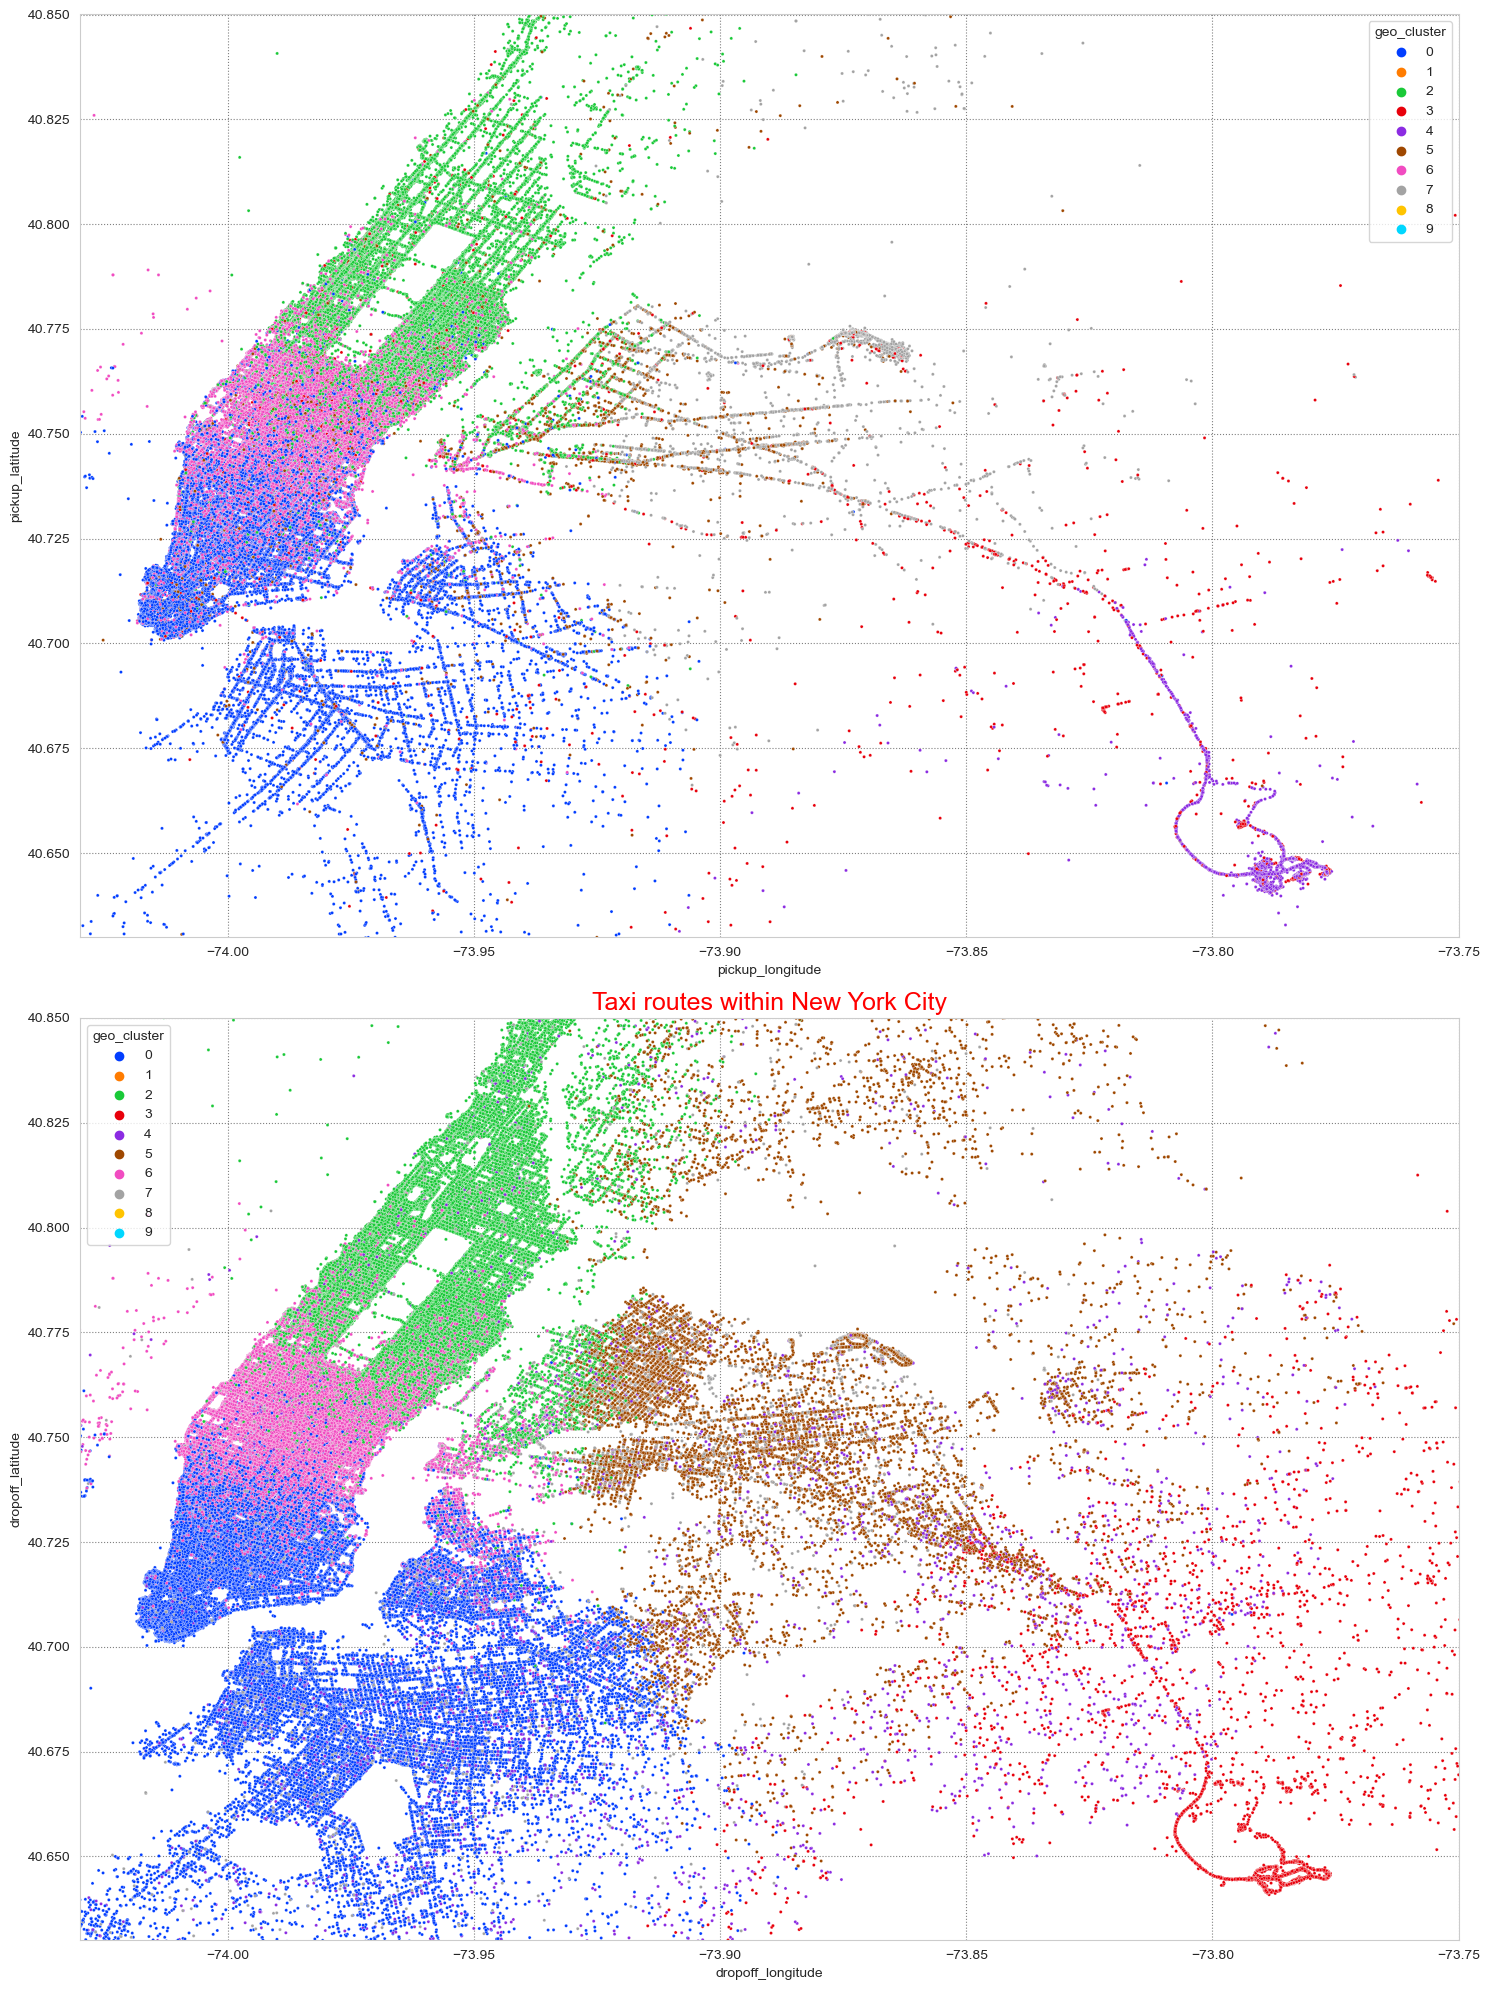

In [47]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(2, figsize=(15,20))
sns.scatterplot(taxi_data, x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', s=5, palette='bright', ax=ax[0])
ax[0].set(xlim=city_long_border, ylim=city_lat_border)
sns.scatterplot(taxi_data, x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', s=5, palette='bright', ax=ax[1])
ax[1].set(xlim=city_long_border, ylim=city_lat_border)
plt.title('Taxi routes within New York City', fontsize=18, color='r')
plt.tight_layout()
plt.show()

***Conclusion:***
*Thursday, Friday, Saturday are the most popular days for taxi drivers.*
The longest trips are from Tuesday to Friday, that is, working days of the week.
The distribution by days of the week is quite smooth and the duration of the trip depending on the day of the week does not show strong fluctuations, it is quite even, which indicates that this feature does not significantly affect the target feature in solving the problem.

# 3.7 Dependence of trip duration (trip_duration) on two factors simultaneously: hours (pickup_hour) and days of the week (pickup_day_of_week).

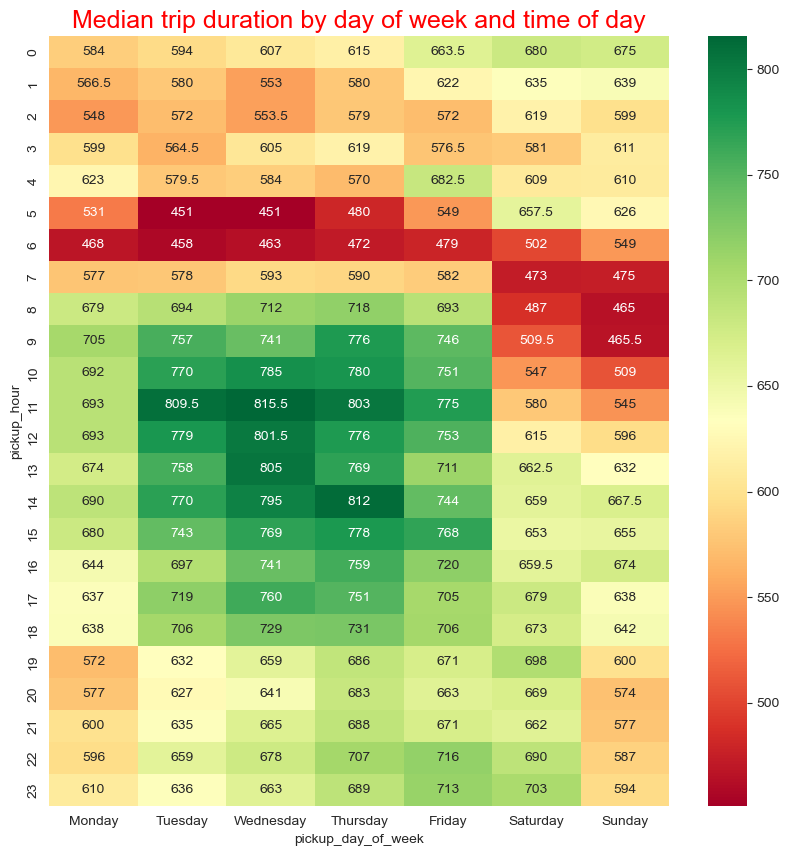

In [33]:
pivot = taxi_data.pivot_table(index='pickup_hour', columns='pickup_day_of_week', values='trip_duration', aggfunc='median')

fig = plt.figure(figsize=(10,10))
p = sns.heatmap(pivot, cmap='RdYlGn', annot=True, fmt='g')
p.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Median trip duration by day of week and time of day', fontsize=18, color='r')
plt.show()

# ***Conclusion:***
According to the heat map, we conclude that these two factors pickup_hour and pickup_day_of_week affect the duration of the trip.

# Regression Plans

The project will involve multiple regression analysis to predict the taxi trip duration. Features such as geo-coordinates, trip distance, and time of day will be utilized in building the regression model.
    
Further I will be using Ensemble learning using

    Linear Regression
    2nd Degree Linear Regression
    Decision Tree
    Random Forest
    Gradient Boosting 

The project aims to deliver a reliable model that helps predict taxi trip durations accurately.